In this notebook, we compare the distribution of the GLM MFX statistic obtained by Monte Carlo simulation with its theoretical distribution.

In [1]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats
from distribution_plots import *

## Description of the Monte Carlo simulation setup
Study level contrast estimates (denoted $\beta_i$'s) and contrast variance estimates (denoted $\sigma_i$'s) were simulated according to:
$$
\beta_i \sim \mathcal{N}(0, \sigma_i^2+\tau^2)
$$

$$
s^2_i \sim \chi^2_{n-1}*\frac{\sigma_i^2}{n-1}
$$

with 
$$
\sigma_i^2 = \frac{\sigma^2*a_i}{n}
$$

where:
 - $\tau^2=1$ is the between-study variance, 
 - $\sigma_i^2$ is the variance of contrast estimate for study i (i.e. the within-study variance divided by $n$) and 
 - $n=20$ is the number of subjects per studies.
 
6 different simulation schemes were computed:
 - 'diff': $\sigma^2_i \in \{0.25, 0.5, 1, 2, 4\}$
 - '05': $\sigma^2_i=\frac{5}{n}=0.25 \; \forall i$
 - '10': $\sigma^2_i=\frac{10}{n}=0.50 \; \forall i$
 - '20': $\sigma^2_i=\frac{20}{n}=1 \; \forall i$
 - '40': $\sigma^2_i=\frac{40}{n}=2 \; \forall i$
 - '80': $\sigma^2_i=\frac{80}{n}=4 \; \forall i$
 
A total of $38*30*30*30$ random sampling were computed.

## Load simulation results

In [2]:
# Simulation parameters
nrep = 38; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study

varcope_sigma2 = [0.25, 0.5, 1, 2, 4]
sigma2 = dict(('{num:02d}'.format(num=int(t*nsubjects)), 
               '$\\tau^2 = 1, \sigma^2_i = ' + str(t) + '$')  
              for t in varcope_sigma2) # Possible within-study variances (constant across studies)
sigma2['diff'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$'
sigma2['diff_1.5'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25-4\}$'
sigma2['diff_1.5'] = '$\\tau^2 = 1, \sigma^2_i \in  \{1-5\}'
sigma2['diff_3'] = '$\\tau^2 = 1, \sigma^2_i \in  \{1-32\}'

kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = kstudies - 1 # Degrees of freedom

In [3]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()

hat_taus = {k: [] for k in sigma2.keys()} # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
tstats = {k: [] for k in sigma2.keys()} # tstat1.nii.gz concatenated across (independent) runs & voxels
zstats = {k: [] for k in sigma2.keys()} # zstat1.nii.gz concatenated across (independent) runs & voxels
meta_varcopes = {k: [] for k in sigma2.keys()} # varcope1.nii.gz concatenated across (independent) runs & voxels
meta_copes = {k: [] for k in sigma2.keys()} # cope1.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2.keys():
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    z_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'zstat1.nii.gz')).get_data().flatten()
    zstats[wth] = np.append(zstats[wth], z_data_array)
    t_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'tstat1.nii.gz')).get_data().flatten()
    tstats[wth] = np.append(tstats[wth], t_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], cope_array)

In [4]:
wth_todisp = ['diff', '05', '80'] # Settings to be displayed

### Look for bias in the random effect variance

In [5]:
for wth in wth_todisp:  
    print('Mean of mean_random_effects_var1 (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          str(np.mean(hat_taus[wth])) + ' / True tau2=' + str(tau2))

Mean of mean_random_effects_var1 (over 1026000 realisations) for diff = 1.07518656485 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for 05 = 1.00886902299 / True tau2=1
Mean of mean_random_effects_var1 (over 1026000 realisations) for 80 = 1.56740477013 / True tau2=1


The random effect variance is possibly positively biased.

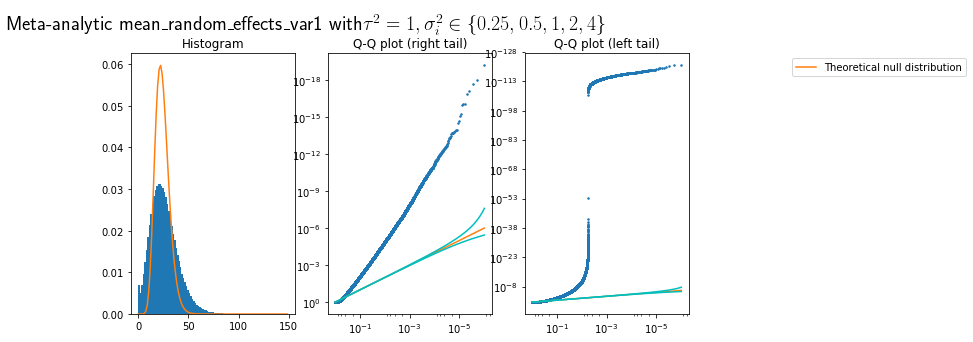

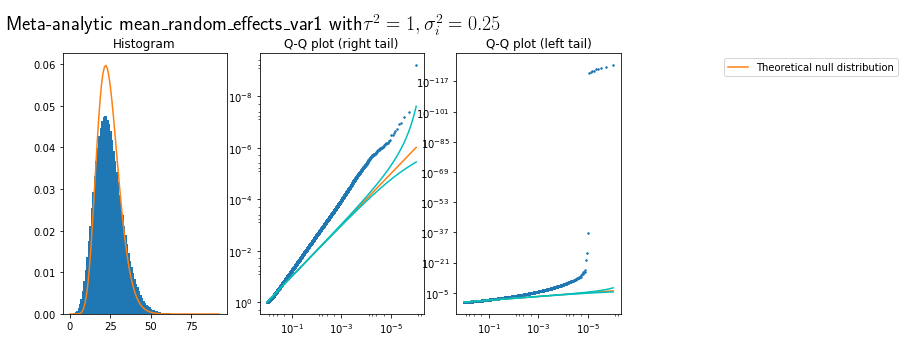

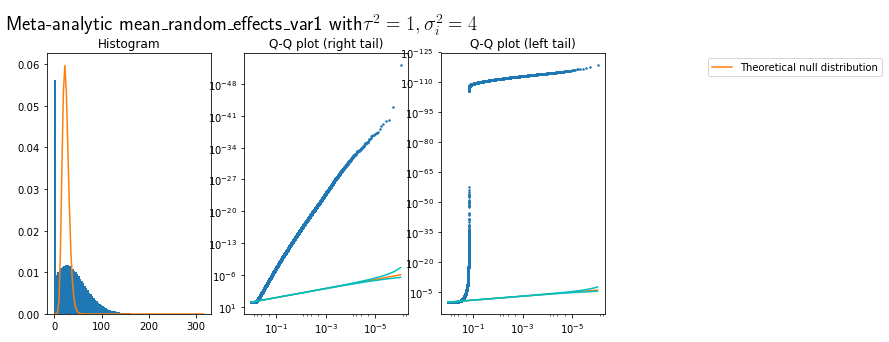

In [6]:
for wth in wth_todisp:
    chi2_distribution_plot(hat_taus[wth]/(tau2/dof), 'Meta-analytic mean\_random\_effects\_var1 with' + sigma2[wth], dof)

Meta-analysic varcopes created with MFX GLM:
 - within-study variance = 5 is valid (almost invalid)
 - within-study variance = 80 is invalid in places (but valid at the tail)
 - varying within-study variance invalid thoughout.
